In [1]:
import numpy as np
import numpy.random as rd
from easyvec import Vec3, Mat3
from interpolation import Interp1d, Interp2d
from math import *
from aero_info import *

In [52]:
class Missile3D(object):
    
    @classmethod
    def get_missile(cls, opts):
        """
        Классовый метод создания ракеты со всеми необходимыми аэродинамическими, массо- и тяговременными характеристиками.
        Ракета является управляемой, использующая самонаведение методом пропорционального сближения.
        
        Arguments
        ---------
        opts : {dict}
               словарь с параметрами ракеты
               
        Returns
        -------
        missile : {cls}
                  экземпляр класса Missile3D
        """
        @np.vectorize
        def get_m(t):
            if t < t_marsh:
                return m_0 - G_marsh * t
            else:
                return m_0 - w_marsh
            
        @np.vectorize
        def get_P(t):
            if t < t_marsh:
                return P_marsh
            else:
                return 0
        
        @np.vectorize
        def get_x_cm(t):
            if t < t_marsh:
                return x_cm_0 - t * (x_cm_0 - x_cm_k) / t_marsh
            else:
                return x_cm_k
        
        @np.vectorize
        def get_x_pres(t):
            if t < t_marsh:
                return x_pres_0 - t * (x_pres_0 - x_pres_k) / t_marsh
            else:
                return x_pres_k
        
        d = opts['d']
        L = opts['L']
        m_0 = opts['m_0']
        v_0 = opts['v_0']
        angle_max = opts['angle_max']
        t_marsh = opts['t_marsh']
        w_marsh = opts['w_marsh']
        P_marsh = opts['P_marsh']
        G_marsh = w_marsh / t_marsh
        r_explosion = opts.get('r_explosion', 25)
        am = opts.get('am', 4.5)
        postProcessing = opts.get('record', True)
        
        x_cm_0 = opts['x_cm_0'] / L
        x_cm_k = opts['x_cm_k'] / L
        x_pres_0 = opts['x_pres_0'] / L
        x_pres_k = opts['x_pres_k'] / L
        x_rule = opts['x_rule'] / L
        
        i = opts.get('i', 1.0)
        # Зависимость Сх от alpha и Mach (невелируется коэффициентом i)
        df1 = pd.read_csv('data_constants/cya_from_mach.csv', sep = ";")
        df2 = pd.read_csv('data_constants/cx_from_mach_and_alpha.csv', sep = ";", index_col=0)
        arr_alpha = np.array(df2.index)
        arr_mach = df1['Mach']
        arr_cx = i * df2.to_numpy()
        Cx_itr = Interp2d(arr_alpha, arr_mach, arr_cx)
        
        arr_alpha = opts['alpha']
        arr_mach = opts['Mach']
        arr_delta = opts['delta']
        arr_cy_alpha = opts['Cy_alpha']
        arr_cy_delta = opts['Cy_delta']
        arr_mz_wz = opts['mz_wz'] 
        arr_mx_delta = opts['mx_delta'] 
        arr_mx_wx = opts['mx_wx']          
        
        ts    = np.linspace(0, t_marsh, 100)
        m_itr = Interp1d(ts, get_m(ts))
        P_itr = Interp1d(ts, get_P(ts))
        atm_itr = table_atm
        Cy_alpha_itr = Interp1d(arr_mach, arr_cy_alpha)
        Cy_delta_itr = Interp1d(arr_mach, arr_cy_delta)
        mz_wz_itr = Interp1d(arr_mach, arr_mz_wz)
        mx_delta_itr = Interp1d(arr_delta, arr_mx_delta)
        mx_wx_itr = Interp1d(arr_mach, arr_mx_wx)
        x_pres_itr = Interp1d(ts, get_x_pres(ts))
        x_mass_itr = Interp1d(ts, get_x_cm(ts))
        
        missile = cls(d=d, m_0=m_0, L=L, v_0=v_0, t_marsh=t_marsh, w_marsh=w_marsh, G_marsh=G_marsh,
                      P_itr=P_itr, m_itr=m_itr, atm_itr=atm_itr,
                      x_rule=x_rule, x_mass_itr=x_mass_itr, x_pres_itr=x_pres_itr,
                      Cx_itr=Cx_itr, Cy_alpha_itr=Cy_alpha_itr, Cy_delta_itr=Cy_delta_itr, mz_wz_itr=mz_wz_itr,
                      mx_wx_itr=mx_wx_itr, mx_delta_itr=mx_delta_itr,
                      angle_max=angle_max, am=am, r_explosion=r_explosion,
                      postProcessing=postProcessing)
        
        return missile
    
    def __init__(self, **kwargs):
        """
        Конструктор класса Missile3D
        
        Attributes
        ----------
        g - ускорение свободного падения (default : 9.80665)
        n - размерность вектора интегрируемых параметров (default : 16)
        t - время (default : 0)
        state - вектор интегрируемых параметров
        state_init - начальный вектор интегрируемых параметров
        d - калибр ракеты или диаметр миделиевого сечения, м
        L - длина ракеты, м
        m_0 - стартовая масса ракеты, кг
        S_mid - площадь миделиеового сечения, м^2
        v - скорость ракеты, м/с
        v_0 - начальная скорость ракеты, м/с
        t_marsh - время работы двигательной установки,с
        w_marsh - начальная масса топлива двигательной установки, кг
        G_marsh - секундный расход топлива двигательной установки, кг/с
        r_explosion - радиус взрыва боевой части ракеты, м
        angle_max - максимальный угол атаки корпуса ракеты, град
        alpha_targeting - потребный угол атаки корпуса ракеты, град (default : 0)
        betta_targeting - потребный угол рыскания корпуса ракеты, град (default : 0)
        delta_alpha - угол отклонения в вертикальной плоскости, град (default : 0)
        delta_betta - угол отклонения в горизонтальной плоскости, град (default : 0)
        P_itr - интерполируемая функция изменения тяги двигательной установки от времени
        m_itr - интерполируемая функция изменения массы ракеты от времени
        Cx_itr - интерполируемая функция изменения коэффициента лобового сопротивления от угла атаки и числа Маха
        Cy_alpha_itr - интерполируемая функция изменения производной коэффициента подъемной силы ракеты по углу атаки от числа Маха
        Cy_delta_itr - интерполируемая функция изменения производной коэффициента подъемной силы ракеты по углу отклонения рулей от числа Маха
        mz_wz_itr - интерполируемая функция изменения производной коэффициента демпфирующего момента
        mx_wx_itr - интерполируемая функция изменения производной коэффициента момента крена ракеты
        mx_delta_itr - интерполируемая функция изменения производной коэффициента момента крена ракеты от угла отклонения элеронов
        x_rule - координата положения оси вращения рулей относительно носа ракеты, м
        x_mass_itr - интерполируемая функция изменения координаты положения центра тяжести по отношению к длине ракеты 
        x_pres_itr - интерполируемая функция изменения координаты положения центра давления по отношению к длине ракеты 
        atm_itr - интерполятор параметров атмосферы
        am - коэффициент быстроты реакции ракеты на маневр цели
        postProcessing - флаг (включатель) записи результатов интегрирования
        history - словарь с результатами интегрирования
        ...
        
        """
        self.g = 9.80665
        self.n = 16
        self.t = 0
        self.state = np.zeros(self.n)
        self.state_init = np.zeros(self.n)
                
        self.d       = kwargs['d']
        self.L       = kwargs['L']
        self.m_0     = kwargs['m_0']
        self.S_mid   = np.pi * self.d**2 / 4
        self.v       = kwargs['v_0']
        self.v_0     = kwargs['v_0']
        self.t_marsh = kwargs['t_marsh']
        self.w_marsh = kwargs['w_marsh']
        self.G_marsh = kwargs['G_marsh']
        self.r_explosion = kwargs['r_explosion']
        self.angle_max = kwargs['angle_max']
        self.alpha_targeting = 0
        self.betta_targeting = 0
        self.delta_alpha = 0
        self.delta_betta = 0

        self.P_itr   = kwargs['P_itr']
        self.m_itr   = kwargs['m_itr']
        self.Cx_itr  = kwargs['Cx_itr']
        self.Cy_alpha_itr = kwargs['Cy_alpha_itr']
        self.Cy_delta_itr = kwargs['Cy_delta_itr']
        self.mz_wz_itr = kwargs['mz_wz_itr']
        self.mx_wx_itr = kwargs['mx_wx_itr']
        self.mx_delta_itr = kwargs['mx_delta_itr']
        self.x_rule = kwargs['x_rule']
        self.x_mass_itr = kwargs['x_mass_itr']
        self.x_pres_itr = kwargs['x_pres_itr']
        self.atm_itr = kwargs['atm_itr']
        self.am = kwargs['am']
        self.postProcessing = kwargs['postProcessing']
        
        self.history = {
            'x': [], 'y': [], 'z': [], 'v_abs': [], 'vx': [], 'vy': [], 'vz': [],
            'wx': [], 'wy': [], 'wz': [], 'qw': [], 'qx': [], 'qy': [], 'qz': [],
            'X': [], 'Y': [], 'Z': [], 'Mx': [], 'My': [], 'Mz': [],
            'thetta': [], 'psi': [], 'gamma': [], 'alpha': [], 'betta': [], 'delta_alpha': [], 'delta_betta': [],
            'alpha_targeting': [], 'betta_targeting': [], 't': []
        }
    
    @property
    def rho(self):
        return self.atm_itr(self.state[1], 3)
    
    @property
    def sonic_speed(self):
        return self.atm_itr(self.state[1], 4)
    
    @property
    def G(self):
        return Vec3(0.0, -self.m_itr(self.t) * self.g, 0.0)
    
    @property
    def m(self):
        return self.m_itr(self.t)
    
    @property
    def P(self):
        return self.P_itr(self.t)
    
    @property
    def J(self):
        if self.t < self.t_marsh:
            Jx = 1/2 * (self.m_0 - self.G_marsh * self.t) * (self.d/2)**2
            Jy = 1/12 * (self.m_0 - self.G_marsh * self.t) * (self.L)**2
            Jz = 1/12 * (self.m_0 - self.G_marsh * self.t) * (self.L)**2
        else:
            Jx = 1/2 * (self.m_0 - self.w_marsh) * (self.d/2)**2
            Jy = 1/12 * (self.m_0 - self.w_marsh) * (self.L)**2
            Jz = 1/12 * (self.m_0 - self.w_marsh) * (self.L)**2
        return (Jx, Jy, Jz)
    
    @property
    def q_abs(self):
        """
        Текущий скоростной напор набегающего потока воздуха
        
        Returns
        -------
        q : float
        """
        return self.rho * self.vel_abs**2 / 2
    
    @property
    def q(self):
        """
        Вектор текущий скоростной напор набегающего потока воздуха
        
        Returns
        -------
        q : {np.ndarray}
        """
        
        return np.array([self.rho * self.vel[0]**2 / 2, self.rho * self.vel[1]**2 / 2, self.rho * self.vel[2]**2 / 2])
    
    @property
    def mach_abs(self):
        """
        Текущее абсолютное значение числа Маха
        
        Returns
        -------
        M : {float}
        """
        return self.vel_abs / self.sonic_speed
    
    @property
    def mach(self):
        """
        Текущее вектор числа Маха
        
        Returns
        -------
        M : {np.ndarray}
            [Mx, My, Mz]
            [0,   1,  2]
        """
        return np.array(self.vel / self.sonic_speed)
    
    @property
    def quaternion(self):
        """
        Кватернион результируюшего текущего поворота (кватернион как четырехмерный вектор)
        
        Returns
        -------
        quaternion : {np.ndarray}
                     q = [qw, qx, qy, qz] 
                         [ 0,  1,  2,  3]
        """
        return np.array([self.qw, self.qx, self.qy, self.qz])
    
    @property
    def norm_quaternion(self):
        """
        Свойство, возвращающее норму кватерниона (длину)
        """
        return np.sqrt(np.dot(self.quaternion, self.quaternion))
    
    @property
    def qw(self):
        return self.state[9]
    
    @property
    def qx(self):
        return self.state[10]
    
    @property
    def qy(self):
        return self.state[11]
    
    @property
    def qz(self):
        return self.state[12]
    
    @property
    def thetta(self):
        """
        Угол тангажа ракеты
        """
        return self.get_angle()[0]
    
    @property
    def psi(self):
        """
        Угол курса ракеты
        """
        return self.get_angle()[1]
    
    @property
    def gamma(self):
        """
        Угол крена ракеты
        """
        return self.get_angle()[2]
     
    @property
    def pos(self):
        """
        Пространственный вектор положения ракеты в ГСК
        
        Returns
        -------
        cls Vec3
        [x, y, z] 
        [0, 1, 2]
        """
        return Vec3(self.state[0], self.state[1], self.state[2])
       
    @property
    def vel(self):
        """
        Пространственный вектор скорости ракеты
        
        Returns
        -------
        cls Vec3
        [vx, vy, vz] 
        [0,   1,  2]
        """
        return Vec3(self.state[3], self.state[4], self.state[5])
    
    @property
    def vel_abs(self):
        return np.sqrt(self.vel.dot(self.vel))
    
    @property
    def w(self):
        """
        Пространственный вектор углового вращения ракеты в ССК
        
        Returns
        -------
        cls Vec3
        [wx, wy, wz] 
        [0,   1,  2]
        """
        return Vec3(self.state[6], self.state[7], self.state[8])
    
    @property
    def wx(self):
        return self.state[6]
    
    @property
    def wy(self):
        return self.state[7]
    
    @property
    def wz(self):
        return self.state[8]
    
    @property
    def alpha(self):
        return self.state[13]
    
    @property
    def betta(self):
        return self.state[14]
    
    @property
    def X(self):
        return self.Cx_itr(self.alpha, self.mach_abs) * self.q_abs * self.S_mid if self.vel_abs > 1e-5 else 0
    
    @property
    def Y(self):
        return (self.Cy_alpha_itr(self.mach_abs) * self.alpha * self.q_abs * self.S_mid +\
                self.Cy_delta_itr(self.mach_abs) * self.delta_alpha * self.q_abs * self.S_mid) if self.vel_abs > 1e-5 else 0
    
    @property
    def Z(self):
        return (self.Cy_alpha_itr(self.mach_abs) * self.betta * self.q_abs * self.S_mid +\
                self.Cy_delta_itr(self.mach_abs) * self.delta_betta * self.q_abs * self.S_mid) if self.vel_abs > 1e-5 else 0
    
    @property
    def Force_inertial(self):
        Fx, Fy, Fz = self._matrix_transition() * Vec3(self.P - self.X, self.Y, self.Z)
        Fy -= np.linalg.norm(self.G)
        return Vec3(Fx, Fy, Fz)
    
    @property
    def Mx(self):
        return 0
    
    @property
    def My(self):
        return (self.Cy_alpha_itr(self.mach_abs) * self.betta * (self.x_mass_itr(self.t) - self.x_pres_itr(self.t)) * self.q_abs * self.S_mid * self.L +\
                self.mz_wz_itr(self.mach_abs) * self.q_abs * self.S_mid * self.L**2 / self.vel_abs * self.wy -\
                self.Cy_delta_itr(self.mach_abs) * self.delta_betta * (self.x_mass_itr(self.t) - self.x_rule) * self.q_abs * self.S_mid * self.L)
    
    @property
    def Mz(self):
        return (self.Cy_alpha_itr(self.mach_abs) * self.alpha * (self.x_mass_itr(self.t) - self.x_pres_itr(self.t)) * self.q_abs * self.S_mid * self.L +\
                self.mz_wz_itr(self.mach_abs) * self.q_abs * self.S_mid * self.L**2 / self.vel_abs * self.wz -\
                self.Cy_delta_itr(self.mach_abs) * self.delta_alpha * (self.x_mass_itr(self.t) - self.x_rule) * self.q_abs * self.S_mid * self.L)
    
    @property
    def Moment_related(self):
        return Vec3(self.Mx, self.My, self.Mz)
    
    def f_system(self, t, Y):
        """
        Функция, записывающая правую часть системы ОДУ динамики материального тела в пространстве.
        
        Arguments
        ---------
        t : {float}
            Время в секундах
        y : {np.ndarray / list}
            Вектор состояния системы 
            [0, 1, 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,    13,    14]
            [x, y, z, vx, vy, vz, wx, wy, wz, qw, qx, qy, qz, alpha, betta]     
            
        Returns
        -------
        dy : {np.ndarray / list}
             Вектор состояния после дифференцирования системы dy/dt
             [0,   1,  2,  3,  4,  5,    6,    7,    8,   9,  10,  11,  12,     13,     14]
             [vx, vy, vz, ax, ay, az, epsx, epsy, epsz, dqw, dqx, dqy, dqz, dalpha, dbetta]
        """
        x, y, z, vx, vy, vz, wx, wy, wz, qw, qx, qy, qz, alpha, betta = Y
        
        self.state = np.append(Y, t)
        self.t = t
        
        self.delta_alpha = self.alpha_targeting - alpha
        self.delta_betta = self.betta_targeting - betta
        
        J_x, J_y, J_z = self.J
        Fx, Fy, Fz = self.Force_inertial
        Mx, My, Mz = self.Moment_related
        
        dY = np.zeros(self.n - 1)

        # dr/dt
        dY[0] = vx
        dY[1] = vy
        dY[2] = vz
        
        # dv/dt = a
        dY[3] = Fx / self.m_itr(t)
        dY[4] = Fy / self.m_itr(t)
        dY[5] = Fz / self.m_itr(t)
        
        # domega/dt = eps
        dY[6] = (Mx + (J_y - J_z) * wy * wz) / J_x 
        dY[7] = (My + (J_z - J_x) * wz * wx) / J_y
        dY[8] = (Mz + (J_x - J_y) * wx * wy) / J_z
        
        # dq/dt
        dY[9] = -1/2 * (qx * wx + qy * wy + qz * wz) 
        dY[10] = 1/2 * (qw * wx - qz * wy + qy * wz)
        dY[11] = 1/2 * (qw * wy - qx * wz + qz * wx)
        dY[12] = 1/2 * (qw * wz - qy * wx + qx * wy)
        
        # dalpha/dt
        dY[13] = self.alpha_targeting - alpha
        dY[14] = self.betta_targeting - betta
                        
        return dY
       
    def step(self, action, tau=0.1, n=10):
        """
        Метод моделирования динамики ракеты за шаг по времени tau
        На протяжении tau управляющее воздействие на ракету постоянно (action)
        Шаг интегирования dt определяется из числа разбиения n временного шага tau
        Функция меняет внутреннее состояние ракеты state на момент окончания шага
        
        Arguments
        ---------
        action : {tuple}
                 управляющее воздействие на протяжении шага
        tau    : {float} 
                 длина шага по времени (не путать с шагом интегрирования)
        n      : {int}
                 число шагов разбиений интервала времени tau
            
        Returns
        -------
        None
        """
        self.alpha_targeting = self.angle_max * action[0]
        self.betta_targeting = self.angle_max * action[1]
        
        y = self._validate_y(self.state[:-1])
        t = self.state[-1]
        
        t_end = t + tau
        dt = tau / n
        
        flag = True
        while flag:
            
            if t_end - t > dt:
                dt = dt 
            
            else:
                dt = t_end - t
                flag = False
                
            k1 = self.f_system(t, y)
            k2 = self.f_system(t + 0.5 * dt, self._validate_y(y + 0.5 * dt * k1))
            k3 = self.f_system(t + 0.5 * dt, self._validate_y(y + 0.5 * dt * k2))
            k4 = self.f_system(t + dt,       self._validate_y(y + dt * k3))
            y  = self._validate_y(y + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4))
            
            t += dt
            self.t = t
            self.state = np.append(y, t)
            
            if self.postProcessing:
                self.history['x'].append(y[0])
                self.history['y'].append(y[1])
                self.history['z'].append(y[2])
                self.history['vx'].append(y[3])
                self.history['vy'].append(y[4])
                self.history['vz'].append(y[5])
                self.history['wx'].append(y[6])
                self.history['wy'].append(y[7])
                self.history['wz'].append(y[8])
                self.history['qw'].append(y[9])
                self.history['qx'].append(y[10])
                self.history['qy'].append(y[11])
                self.history['qz'].append(y[12])
                self.history['t'].append(t)
                self.history['v_abs'].append(self.vel_abs)
                self.history['thetta'].append(self.thetta)
                self.history['psi'].append(self.psi)
                self.history['gamma'].append(self.gamma)
                self.history['alpha'].append(y[13])
                self.history['betta'].append(y[14])
                self.history['delta_alpha'].append(self.delta_alpha)
                self.history['delta_betta'].append(self.delta_betta)
                self.history['alpha_targeting'].append(self.alpha_targeting)
                self.history['betta_targeting'].append(self.betta_targeting)
                self.history['X'].append(self.X)
                self.history['Y'].append(self.Y)
                self.history['Z'].append(self.Z)
                self.history['Mx'].append(self.Mx)
                self.history['My'].append(self.My)
                self.history['Mz'].append(self.Mz)
        
    def get_angle(self):
        """
        Метод, вычисляющий самолетные углы Крылова по текущему кватерниону поворота
        
        Returns
        -------
        np.ndarray
        [thetta, psi, gamma]
        """
        C = self._matrix_transition()
        qw, qx, qy, qz = self.qw, self.qx, self.qy, self.qz
        thetta = np.arctan2(2 * (qx * qy + qw * qz), 2 * (qw**2 + qx**2) - 1)
        psi = -np.arctan2(C[2][0], C[0][0]) # np.arcsin(2*(qw*qy-qx*qz))  
        gamma = -np.arctan2(2 * (qy * qz - qw * qx), 2 * (qw**2 + qy**2) - 1)
        return np.array([thetta, psi, gamma])
    
    def get_initial_parameters_of_missile(self, target):
        """
        Метод, возвращающий начальное состояние ракеты, направленной в ракету
        
        Arguments:
        ---------
        target : object cls target
        
        Returns
        -------
        np.ndarray [x, y, z, vx, vy, vz, wx, wy, wz, qw, qx, qy, qz, alpha, betta, t]
        """
        meeting_point = np.array(target.pos)
        visir = meeting_point - self.pos
        visir_len = np.linalg.norm(visir)
        thetta = np.arctan2(visir[1], visir[0])
        qw, qx, qy, qz = self.get_initial_quaternion(meeting_point)
        vx, vy, vz = self.v_0 * np.cos(thetta), self.v_0 * np.sin(thetta), 0
        return np.array([0, 0, 0, vx, vy, vz, 0, 0, 0, qw, qx, qy, qz, 0, 0, 0])   
        
    def set_initial_parameters_of_missile(self, target, parameters_of_missile=None):
        """
        Метод, устанавливающий начальные параметры (положение, линейную скорость, угловую скорость, кватернион, время)
        
        Arguments:
        ---------
        target                : {object cls target}
        parameters_of_missile : {list / np.ndarray / None} (default : None)
                                [x, y, z, vx, vy, vz, wx, wy, wz, qw, qx, qy, qz, alpha, betta, t]
        
        Returns
        -------
        None
        """
        if parameters_of_missile is None:    
            parameters_of_missile = self.get_initial_parameters_of_missile(target)
        self.state = np.array(parameters_of_missile)
        self.state_init = np.array(parameters_of_missile)
    
    def reset(self):
        """
        Метод, возвращающий ракету в начальное состояние
        """
        self.state = self.state_init
    
    def get_initial_quaternion(self, target_pos):
        """
        Метод, возвращающий значение начального нормированного кватерниона поворота ССК в ИСК
        Примечание: при обнаружении цели направление ИСК таково, что ее ось Х направлена в сторону цели,
        а ССК поворачивается относительно оси Z ИСК на угол тангажа Thetta
        
        Arguments:
        ---------
        target_pos : {list/tuple/np.ndarray}
                     координата цели
        
        Returns
        -------
        np.ndarray
        [qw, qx, qy, qz]
        """
        line_visir = np.array(target_pos - self.pos)
        thetta_init = np.arctan2(line_visir[1], line_visir[0])
        thetta, psi, gamma = thetta_init, 0.0, 0.0
        qw = np.cos(thetta/2) * np.cos(psi/2) * np.cos(gamma/2) + np.sin(thetta/2) * np.sin(psi/2) * np.sin(gamma/2)
        qx = np.cos(thetta/2) * np.cos(psi/2) * np.sin(gamma/2) - np.sin(thetta/2) * np.sin(psi/2) * np.cos(gamma/2)
        qy = np.cos(thetta/2) * np.sin(psi/2) * np.cos(gamma/2) + np.sin(thetta/2) * np.cos(psi/2) * np.sin(gamma/2)
        qz = np.sin(thetta/2) * np.cos(psi/2) * np.cos(gamma/2) - np.cos(thetta/2) * np.sin(psi/2) * np.sin(gamma/2)
        norm_quaternion = np.sqrt(qw**2 + qx**2 + qy**2 + qz**2)
        return np.array([qw, qx, qy, qz]) / norm_quaternion
    
    def get_action_proportional_guidance(self, target, am=None):
        """
        Метод класса, соответствующий методу пропорциональной навигации
        
        Arguments
        ---------
        target : {object cls Target}
        am: int / float / None (default : None)
            Коэффициент пропорциональности, показывающий быстроту реакции ракеты на маневр цели.
            Если не указан, то коэффициент берется либо из словаря opts начальных данных,
            либо же по умолчанию в классовом методе get_missile() прописано значение 4,5.
        
        Returns
        -------
        action : {tuple}
                 [float, float]
        """
        am  = self.am if am == None else am
        
        trg_pos_vertical = np.array(Vec3(target.pos[0], target.pos[1], 0))
        trg_vel_vertical = np.array(target.vel - (Vec3(0,0,1).dot(target.vel) * Vec3(0,0,1)))
        mis_pos_vertical = np.array(Vec3(self.pos[0], self.pos[1], 0))
        mis_vel_vertical = np.array(self.vel - (Vec3(0,0,1).dot(self.vel) * Vec3(0,0,1)))
        
        trg_pos_horizontal = np.array(Vec3(target.pos[0], 0, target.pos[2]))
        trg_vel_horizontal = np.array(target.vel - (Vec3(0,1,0).dot(target.vel) * Vec3(0,1,0)))
        mis_pos_horizontal = np.array(Vec3(self.pos[0], 0, self.pos[2]))
        mis_vel_horizontal = np.array(self.vel - (Vec3(0,1,0).dot(self.vel) * Vec3(0,1,0)))
               
        # Вертикальная плоскость
        vis_vertical = trg_pos_vertical - mis_pos_vertical
        r_vertical = np.linalg.norm(vis_vertical)
        vis1_vertical = vis_vertical / r_vertical
        vel_otn_vertical = trg_vel_vertical - mis_vel_vertical
        vel_otn_tau_vertical = vis1_vertical * np.dot(vis1_vertical, vel_otn_vertical)
        vel_otn_n_vertical = vel_otn_vertical - vel_otn_tau_vertical
        
        # Горизонтальная плоскость
        vis_horizontal = trg_pos_horizontal - mis_pos_horizontal
        r_horizontal = np.linalg.norm(vis_horizontal)
        vis1_horizontal = vis_horizontal / r_horizontal
        vel_otn_horizontal = trg_vel_horizontal - mis_vel_horizontal
        vel_otn_tau_horizontal = vis1_horizontal * np.dot(vis1_horizontal, vel_otn_horizontal)
        vel_otn_n_horizontal = vel_otn_horizontal - vel_otn_tau_horizontal
        
        # Производные углов визирования
        fi_vertical_der = copysign(np.linalg.norm(vel_otn_n_vertical) / r_vertical,
                                   np.cross(vis1_vertical[:-1], vel_otn_n_vertical[:-1]))
        vis1_horizontal = list(vis1_horizontal[:1]) + list(vis1_horizontal[2:])
        vel_otn_n_horizontal = list(vel_otn_n_horizontal[:1]) + list(vel_otn_n_horizontal[2:])
        fi_horizontal_der = copysign(np.linalg.norm(vel_otn_n_horizontal) / r_horizontal,
                                     np.cross(vis1_horizontal, vel_otn_n_horizontal))

        # Проивзодные углов наклона ракеты
        thetta_der = am * fi_vertical_der
        psi_der = am * fi_horizontal_der
        
        vel_v_abs = np.linalg.norm(mis_vel_vertical)
        vel_h_abs = np.linalg.norm(mis_vel_horizontal)
        
        # Потребные перегрузки
        nYv = vel_v_abs * thetta_der / self.g + np.cos(self.thetta) 
        nYh = vel_h_abs * psi_der / self.g
        
        # Балансировочные углы
        alpha = (nYv * self.m * self.g) / (self.Cy_alpha_itr(self.mach_abs) * self.q_abs * self.S_mid +\
                                             self.Cy_delta_itr(self.mach_abs) * self.q_abs * self.S_mid + self.P / 57.3)
        betta = (nYh * self.m * self.g) / (self.Cy_alpha_itr(self.mach_abs) * self.q_abs * self.S_mid +\
                                            self.Cy_delta_itr(self.mach_abs) * self.q_abs * self.S_mid + self.P / 57.3)
        
        return (alpha/self.angle_max, betta/self.angle_max)
    
    def to_dict(self):
        return {
            't': self.history['t'],
            'pos': [(self.history['x'][i], self.history['y'][i], self.history['z'][i]) for i in range(len(self.history['t']))],
            'vel': [(self.history['vx'][i], self.history['vy'][i], self.history['vz'][i]) for i in range(len(self.history['t']))],
            'q': [(self.history['qw'][i], self.history['qx'][i], self.history['qy'][i], self.history['qz'][i]) for i in range(len(self.history['x']))],
            'w': [(self.history['wx'][i], self.history['wy'][i], self.history['wz'][i]) for i in range(len(self.history['t']))],
        }    
        
    def _matrix_transition(self):
        """
        Вспомогательный метод, образующий матрицу перехода от ССК к ИСК из параметров Родрига-Гамильтона
        
        Returns
        -------
        Mat3
        |C11, C12, C13|
        |C21, C22, C23|
        |C31, C32, C33|
        """
        qw, qx, qy, qz = self.quaternion
        
        C11 = 2 * (qw**2 + qx**2) - 1
        C12 = 2 * (qx * qy - qw * qz)
        C13 = 2 * (qx * qz + qw * qy)
        C21 = 2 * (qx * qy + qw * qz)
        C22 = 2 * (qw**2 + qy**2) - 1
        C23 = 2 * (qy * qz - qw * qx)
        C31 = 2 * (qx * qz - qw * qy)
        C32 = 2 * (qy * qz + qw * qx)
        C33 = 2 * (qw**2 + qz**2) - 1
        
        C1 = Vec3(C11, C12, C13)
        C2 = Vec3(C21, C22, C23)
        C3 = Vec3(C31, C32, C33)
        
        return Mat3(*C1, *C2, *C3)
    
    def _validate_y(self, y):
        """
        Вспомогательный метод класса проверки вектора состояния ракеты на заброс углов атаки и скольжения
        """
        # validate alpha
        if y[13] > self.angle_max:
            y[13] = self.angle_max
        elif y[13] < -self.angle_max:
            y[13] = -self.angle_max
        elif abs(y[13] - self.alpha_targeting) < 1e-4:
            y[13] = self.alpha_targeting
        
        # validate betta
        if y[14] > self.angle_max:
            y[14] = self.angle_max
        elif y[14] < -self.angle_max:
            y[14] = -self.angle_max
        elif abs(y[14] - self.betta_targeting) < 1e-4:
            y[14] = self.betta_targeting

        return y

# TEST LAUNCH

In [53]:
opts = {
    'd': 0.230,
    'L': 2.89,
    'm_0': 165,
    'v_0': 25,
    't_marsh': 6,
    'w_marsh': 53,
    'P_marsh': 22.5*1e3,
    'r_explosion': 50,
    'angle_max': 12,
    'a_m': 3,
    'record': True,
    'x_cm_0': 1.81,
    'x_cm_k': 1.7,
    'x_pres_0': 1.87,
    'x_pres_k': 1.8,
    'x_rule': 0.6,
    'alpha': np.array([-10, -7, -5, -3, -1, 0, 1, 3, 5, 7, 10]),
    'Mach': np.array([0.3, 0.6, 0.9, 1, 1.1, 1.4, 1.7, 2.0, 2.3]),
    'delta': np.array([-15, 0, 15]),
    'Cy_alpha': np.array([0.2, 0.3, 0.35, 0.4, 0.35, 0.3, 0.25, 0.225, 0.2]),
    'Cy_delta': np.array([0.10, 0.15, 0.20, 0.25, 0.20, 0.15, 0.12, 0.11, 0.10]),
    'mz_wz': np.array([-30, -35, -40, -40, -35, -30, -25, -20, -15]),
    'mx_wx': np.array([0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45]),
    'mx_delta': np.array([1.0, 0, -1.0]),
    'i': 1.0
}

In [54]:
# mis.Cx_itr.plot()
# mis.Cy_alpha_itr.plot()

In [55]:
mis = Missile3D.get_missile(opts)

In [77]:
# настройка шрифтов
rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]

In [56]:
from Target3D import Target3D
import matplotlib.pyplot as plt
from tqdm import tqdm

In [57]:
trg = Target3D.get_simple_target(pos=Vec3(8e3, 1.5e3, 0),
                                 aim=Vec3(-100, 0, 100),
                                 vel=Vec3(-100, 10, 10),
                                 vel_aim=Vec3(-100, -10, -10),
                                 time_min=False)
mis.set_initial_parameters_of_missile(trg)

In [58]:
mis._matrix_transition() * Vec3(1, 0, 0)

Vec3(0.982872186934322, 0.18428853505018536, 0.0)

In [59]:
mis.Force_inertial

Vec3(22111.532054968873, 2527.8150103066637, 0.0)

In [60]:
traj = trg.get_traject(trg.fly_time)

In [61]:
dt = 0.1
n = 5

In [62]:
# mis.reset()

In [63]:
for i in tqdm(range(150)):
    trg.step(tau=dt, n=n)
    mis.step(mis.get_action_proportional_guidance(trg), tau=dt, n=n)
    if np.sqrt((trg.pos[0]-mis.pos[0])**2 + (trg.pos[1]-mis.pos[1])**2 + (trg.pos[2]-mis.pos[2])**2) < mis.r_explosion:
        break

 73%|██████████████████████████████████████████████████████████▏                     | 109/150 [09:13<03:28,  5.08s/it]


In [64]:
%matplotlib inline

In [65]:
res_trg = trg.to_dict()

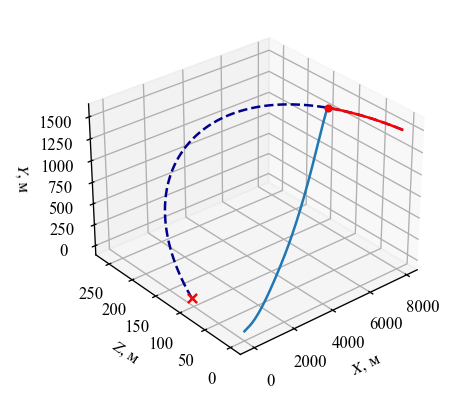

In [78]:
# %matplotlib
fig = plt.figure(dpi=120)
ax = plt.axes(projection='3d')
ax.plot(traj[:,0], traj[:,2], traj[:,1], ls='--', color='darkblue')
ax.plot(mis.history['x'], mis.history['z'], mis.history['y'])
ax.plot(res_trg['x'], res_trg['z'], res_trg['y'], color='red')
ax.scatter(res_trg['x'][-1], res_trg['z'][-1], res_trg['y'][-1],  marker='o', color='red', s=15)
ax.scatter(traj[:,0][-1], traj[:,2][-1], traj[:,1][-1], marker='x', color='red', s=30)
ax.set_xlabel('$X$, м')
ax.set_ylabel('$Z$, м')
ax.set_zlabel('$Y$, м')
ax.view_init(elev=30, azim=-130)
plt.show()

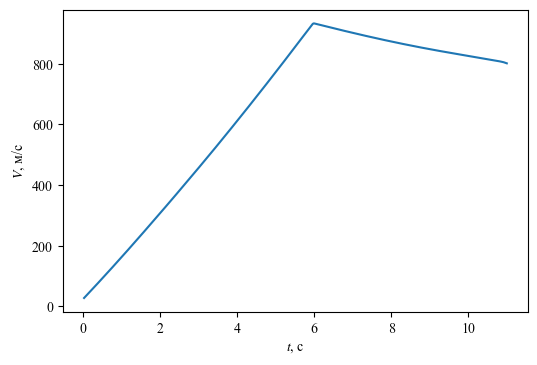

In [67]:
plt.figure(dpi=100)
plt.plot(mis.history['t'], mis.history['v_abs'])
plt.xlabel('$t$, c')
plt.ylabel('$V$, м/c')
plt.show()

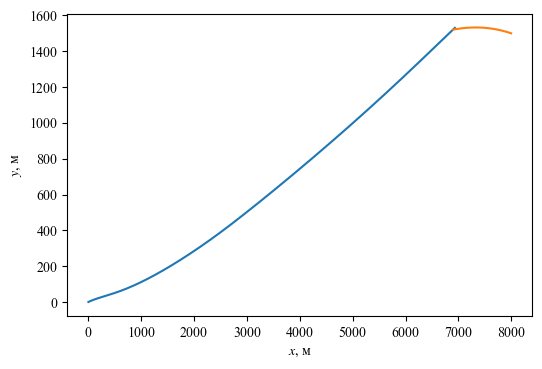

In [68]:
plt.figure(dpi=100)
plt.plot(mis.history['x'], mis.history['y'])
plt.plot(res_trg['x'], res_trg['y'])
plt.xlabel('$x$, м')
plt.ylabel('$y$, м')
plt.show()

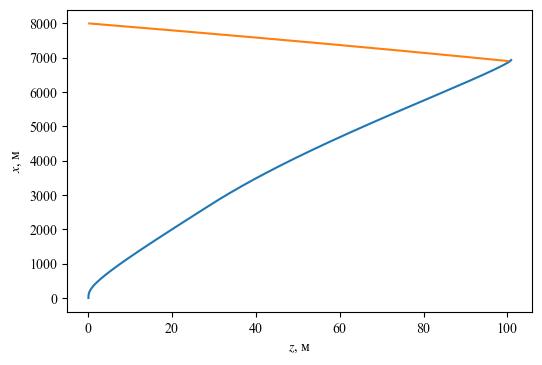

In [69]:
plt.figure(dpi=100)
plt.plot(mis.history['z'], mis.history['x'])
plt.plot(res_trg['z'], res_trg['x'])
plt.xlabel('$z$, м')
plt.ylabel('$x$, м')
plt.show()

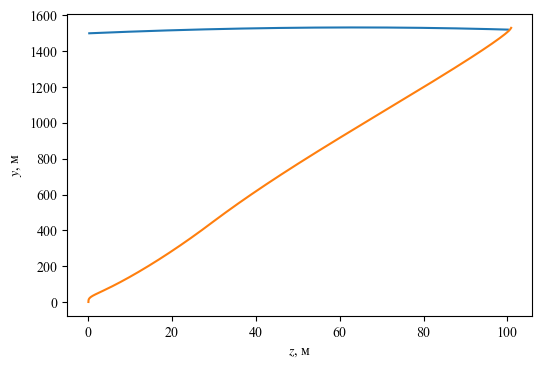

In [70]:
plt.figure(dpi=100)
plt.plot(res_trg['z'], res_trg['y'])
plt.plot(mis.history['z'], mis.history['y'])
plt.xlabel('$z$, м')
plt.ylabel('$y$, м')
plt.show()

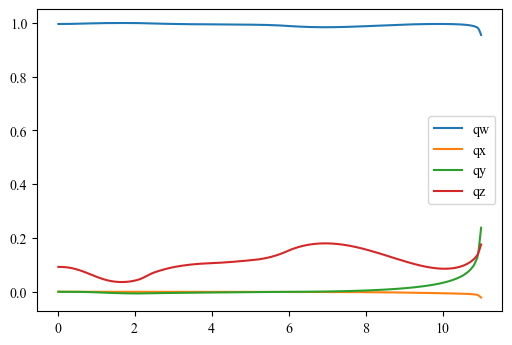

In [71]:
plt.figure(dpi=100)
plt.plot(mis.history['t'], mis.history['qw'], label='qw')
plt.plot(mis.history['t'], mis.history['qx'], label='qx')
plt.plot(mis.history['t'], mis.history['qy'], label='qy')
plt.plot(mis.history['t'], mis.history['qz'], label='qz')
plt.legend()
plt.show()

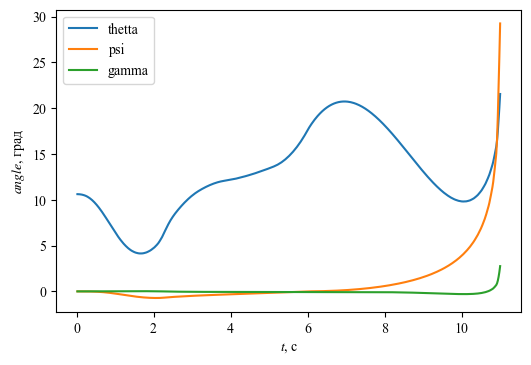

In [72]:
plt.figure(dpi=100)
plt.plot(mis.history['t'], np.degrees(mis.history['thetta']), label='thetta')
plt.plot(mis.history['t'], np.degrees(mis.history['psi']), label='psi')
plt.plot(mis.history['t'], np.degrees(mis.history['gamma']), label='gamma')
plt.xlabel('$t$, c')
plt.ylabel('$angle$, град')
plt.legend()
plt.show()

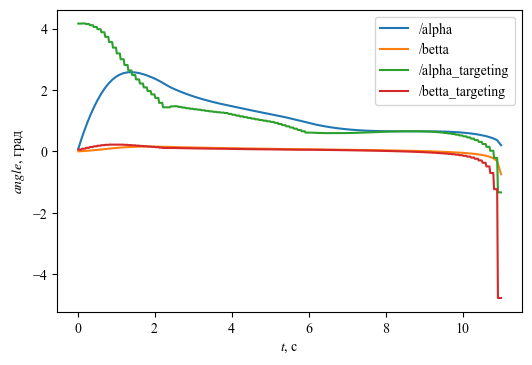

In [73]:
plt.figure(dpi=100)
plt.plot(mis.history['t'], mis.history['alpha'], label='/alpha')
plt.plot(mis.history['t'], mis.history['betta'], label='/betta')
plt.plot(mis.history['t'], mis.history['alpha_targeting'], label='/alpha_targeting')
plt.plot(mis.history['t'], mis.history['betta_targeting'], label='/betta_targeting')
plt.xlabel('$t$, c')
plt.ylabel('$angle$, град')
plt.legend()
plt.show()

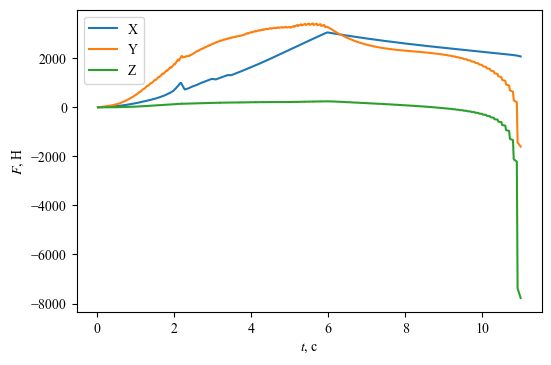

In [74]:
plt.figure(dpi=100)
plt.plot(mis.history['t'], mis.history['X'], label='X')
plt.plot(mis.history['t'], mis.history['Y'], label='Y')
plt.plot(mis.history['t'], mis.history['Z'], label='Z')
plt.xlabel('$t$, c')
plt.ylabel('$F$, Н')
plt.legend()
plt.show()

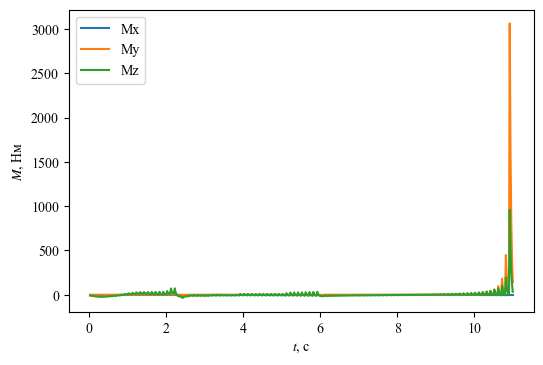

In [75]:
plt.figure(dpi=100)
plt.plot(mis.history['t'], mis.history['Mx'], label='Mx')
plt.plot(mis.history['t'], mis.history['My'], label='My')
plt.plot(mis.history['t'], mis.history['Mz'], label='Mz')
plt.xlabel('$t$, c')
plt.ylabel('$M$, Нм')
plt.legend()
plt.show()

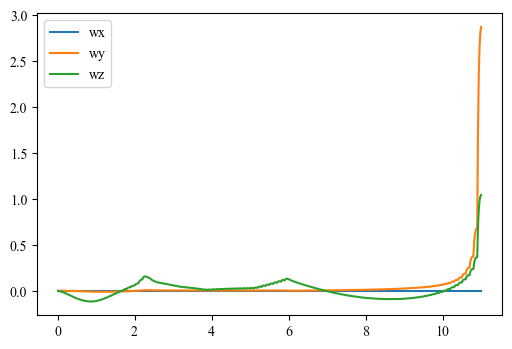

In [76]:
plt.figure(dpi=100)
plt.plot(mis.history['t'], mis.history['wx'], label='wx')
plt.plot(mis.history['t'], mis.history['wy'], label='wy')
plt.plot(mis.history['t'], mis.history['wz'], label='wz')
plt.legend()
plt.show()